In [14]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import statsmodels.api as sm
from scipy import stats

In [15]:
# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [16]:
path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")


In [17]:
# --- Grundwahrscheinlichkeiten ---
p_fraud = ds["is_fraud"].mean()
p_male  = (ds["gender"] == "M").mean()
p_female = (ds["gender"] == "F").mean()

# --- P(Male | Fraud) ---
p_male_given_fraud = ds.loc[ds["is_fraud"] == 1, "gender"].eq("M").mean()
p_female_given_fraud = ds.loc[ds["is_fraud"] == 1, "gender"].eq("F").mean()

# --- Bayes: P(Fraud | Male) und P(Fraud | Female) ---
p_fraud_given_male = (p_male_given_fraud * p_fraud) / p_male
p_fraud_given_female = (p_female_given_fraud * p_fraud) / p_female

print("Bayes-berechnete bedingte Wahrscheinlichkeiten:")
print(f"P(Fraud | Male)   = {p_fraud_given_male:.6f}")
print(f"P(Fraud | Female) = {p_fraud_given_female:.6f}")

# --- Risiko-Maß: Risk Ratio (Relatives Risiko) ---
risk_ratio = p_fraud_given_male / p_fraud_given_female
print(f"\nRisikomaß (Risk Ratio) Männer vs. Frauen: {risk_ratio:.3f}")

Bayes-berechnete bedingte Wahrscheinlichkeiten:
P(Fraud | Male)   = 0.006426
P(Fraud | Female) = 0.005262

Risikomaß (Risk Ratio) Männer vs. Frauen: 1.221


Risikomaße nach Kategorie:
                P(Fraud|Category)  Risk Difference  Risk Ratio  Odds Ratio
category                                                                  
shopping_net               0.0176           0.0118      3.0338      3.0701
misc_net                   0.0145           0.0087      2.4976      2.5196
grocery_pos                0.0141           0.0083      2.4354      2.4559
shopping_pos               0.0072           0.0014      1.2482      1.2500
gas_transport              0.0047          -0.0011      0.8109      0.8100
misc_pos                   0.0031          -0.0027      0.5422      0.5407
grocery_net                0.0029          -0.0028      0.5093      0.5078
travel                     0.0029          -0.0029      0.4947      0.4933
entertainment              0.0025          -0.0033      0.4281      0.4267
personal_care              0.0024          -0.0034      0.4188      0.4173
kids_pets                  0.0021          -0.0037      0.3653      0.363

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_18922/1835662561.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


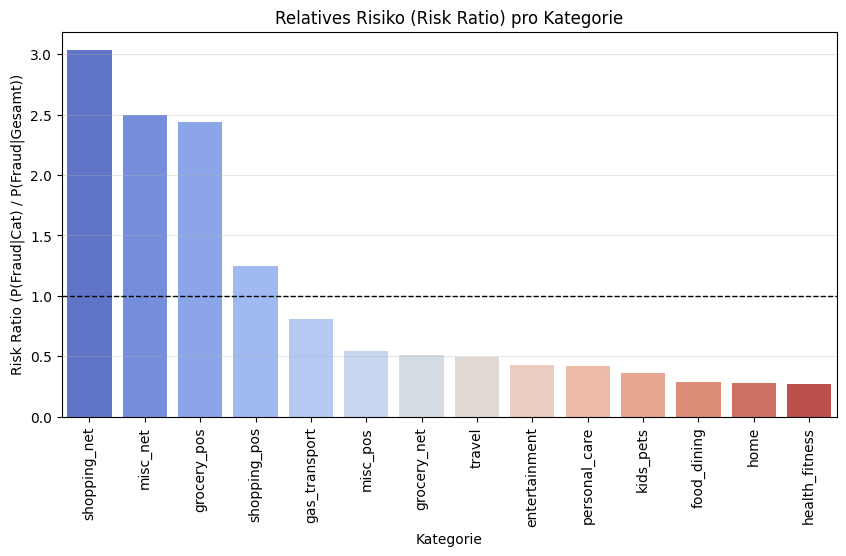

In [ ]:
# --- Grundwahrscheinlichkeit ---
p_fraud_overall = ds["is_fraud"].mean()

# --- Betrugswahrscheinlichkeit pro Kategorie ---
fraud_by_cat = ds.groupby("category")["is_fraud"].mean().sort_values(ascending=False)

# --- Risikomaße berechnen ---
risk_df = pd.DataFrame({
    "P(Fraud|Category)": fraud_by_cat,
    "Risk Difference": fraud_by_cat - p_fraud_overall,
    "Risk Ratio": fraud_by_cat / p_fraud_overall,
    "Odds Ratio": (fraud_by_cat / (1 - fraud_by_cat)) / (p_fraud_overall / (1 - p_fraud_overall))
})

print("Risikomaße nach Kategorie:")
print(risk_df.round(4))

# --- Visualisierung: Relative Risiken (RR) ---
plt.figure(figsize=(10,5))
sns.barplot(
    x=risk_df.index,
    y="Risk Ratio",
    data=risk_df,
    palette="coolwarm"
)
plt.title("Relatives Risiko (Risk Ratio) pro Kategorie")
plt.xlabel("Kategorie")
plt.ylabel("Risk Ratio (P(Fraud|Cat) / P(Fraud|Gesamt))")
plt.xticks(rotation=90)
plt.axhline(1, color="black" ,linestyle="--", linewidth=1)
plt.grid(axis="y", alpha=0.3)
plt.show()

=== Risikomaße nach Beruf (Top 10) ===
                                                    P(Fraud|Job)  \
job                                                                
Personnel officer                                       1.000000   
Air traffic controller                                  1.000000   
Accountant, chartered                                   1.000000   
Ship broker                                             1.000000   
Solicitor                                               1.000000   
Careers adviser                                         1.000000   
Information officer                                     1.000000   
Armed forces technical officer                          1.000000   
Industrial buyer                                        1.000000   
Homeopath                                               1.000000   
Legal secretary                                         1.000000   
Forest/woodland manager                                 1.000000   
Dancer   

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_18922/1339865819.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


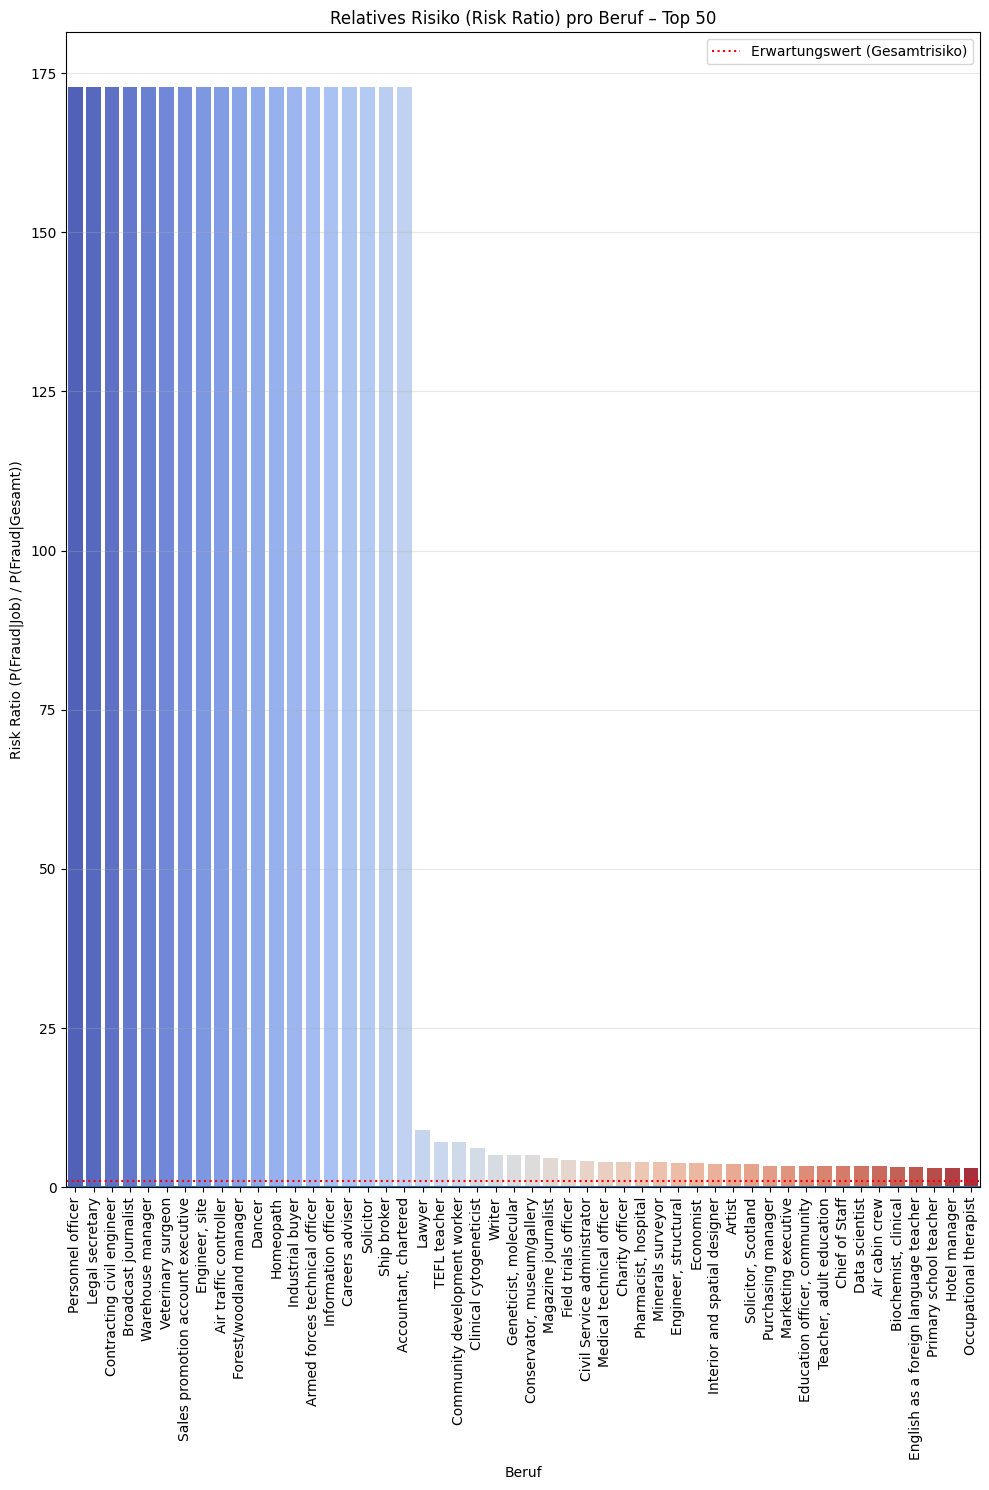

In [28]:
# === Grundwahrscheinlichkeit =============================================
p_fraud_overall = ds["is_fraud"].mean()

# === Betrugswahrscheinlichkeit pro Beruf =================================
fraud_by_job = ds.groupby("job")["is_fraud"].mean().sort_values(ascending=False)

# === Risikomaße berechnen ===============================================
risk_job = pd.DataFrame({
    "P(Fraud|Job)": fraud_by_job,
    "Risk Difference": fraud_by_job - p_fraud_overall,
    "Risk Ratio": fraud_by_job / p_fraud_overall,
    "Odds Ratio": (fraud_by_job / (1 - fraud_by_job)) / (p_fraud_overall / (1 - p_fraud_overall))
}).round(6)

print("=== Risikomaße nach Beruf (Top 10) ===")
pd.set_option('display.max_rows',risk_job.shape[0])
print(risk_job.head(risk_job.shape[0]))

# === Visualisierung: Top 15 Berufe nach Risk Ratio =======================
top_jobs = risk_job.head(50).reset_index()

plt.figure(figsize=(10,15))
sns.barplot(
    data=top_jobs,
    x="job",
    y="Risk Ratio",
    palette="coolwarm",
    order=top_jobs.sort_values("Risk Ratio", ascending=False)["job"]
)
plt.title("Relatives Risiko (Risk Ratio) pro Beruf – Top 50")
plt.xlabel("Beruf")
plt.ylabel("Risk Ratio (P(Fraud|Job) / P(Fraud|Gesamt))")
plt.xticks(rotation=90)
plt.axhline(y=p_fraud_overall / p_fraud_overall, color="red", linestyle=":", linewidth=1.5, label="Erwartungswert (Gesamtrisiko)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.axhline()
plt.tight_layout()
plt.show()